# 0.5 Particles in Harmonic Well

Here we show how to run some basic particle simulations in a harmonic well. We make use of other Python libraries, like getting random numbers and making complex plots.

In [1]:
import hoomd, hoomd.htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as ss
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## Build the computational graph

Our graph is relatively simply. We just compute the distance from the origin and square that to get a harmonic potential.

In [2]:
# set-up graph
directory = 'normal'
graph = hoomd.htf.SimModel(0)
positions = tf.Variable(tf.zeros_like(graph.positions), validate_shape=False, name='positions', trainable=False)
# save positions
save_pos = positions.assign(graph.positions)
# Energy is distance from origin squared
energy = tf.reduce_sum(tf.norm(graph.positions[:,:2], axis=1))
# make it clear to htf that we want to use forces derived from positions, instead of a neighbor list
# by setting positions=True
forces = graph.compute_forces(energy, positions=True)
graph.save(directory,force_tensor=forces, out_nodes=[save_pos])

## Build Initial Config

We make the starting momentum and positions random for our particles and create s snapshot to use in hoomd-blue.

In [3]:
c = hoomd.context.initialize('--mode=cpu')
# set-up initial distribution
p0bar = [[1,0], [0.1,0.1]]
q0bar = [[-3, -1.5], [0.05, 0.05]]
N = 512 # number of particles
T = 1000 # length of trajectories
P = 32 # period of saving positions

snapshot = hoomd.data.make_snapshot(N=N,
                                    box=hoomd.data.boxdim(Lx=100,
                                                          Ly=100,
                                                          Lz=1),
                                    particle_types=['A'])
q0 = np.zeros((N,3))
q0[:,0] = ss.norm.rvs(scale=q0bar[1][0], loc=q0bar[0][0], size=N)
q0[:,1] = ss.norm.rvs(scale=q0bar[1][1], loc=q0bar[0][1], size=N)
p0 = np.zeros((N,3))
p0[:,0] = ss.norm.rvs(scale=p0bar[1][0], loc=p0bar[0][0], size=N)
p0[:,1] = ss.norm.rvs(scale=p0bar[1][1], loc=p0bar[0][1], size=N)

snapshot.particles.position[:] = q0
snapshot.particles.velocity[:] = p0
snapshot.particles.typeid[:] = 0
system = hoomd.init.read_snapshot(snapshot)

HOOMD-blue v2.5.1 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 03/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 512 particles


## Run the simulation
Now we run the simulation in the NVE ensemble. We disable the hoomd-blue sorter, so that the particle ordering doesn't change. This makes it easy to plot the particles

In [4]:
# run Hoomd-blue simulation
with hoomd.htf.tfcompute(directory, device='/CPU:0') as tfcompute:
    tfcompute.attach(save_period=P)
    hoomd.md.integrate.mode_standard(dt=0.001)
    hoomd.md.integrate.nve(group=hoomd.group.all())                                   
    c.sorter.disable()
    hoomd.run(T * P)

notice(2): Started TF Session Manager.
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
notice(2): TF Session Manager has released control. Starting HOOMD updates
** starting run **
Time 00:00:11 | Step 4768 / 32000 | TPS 464.851 | ETA 00:00:58
Time 00:00:21 | Step 10112 / 32000 | TPS 532.047 | ETA 00:00:41
Time 00:00:31 | Step 13725 / 32000 | TPS 361.291 | ETA 00:00:50
Time 00:00:41 | Step 17312 / 32000 | TPS 357.791 | ETA 00:00:41
Time 00:00:51 | Step 21024 / 32000 | TPS 370.706 | ETA 00:00:29
Time 00:01:01 | Step 24480 / 32000 | TPS 345.402 | ETA 00:00:21
Time 00:01:11 | Step 27264 / 32000 | TPS 275.965 | ETA 00:00:17
Time 00:01:21 | Step 30801 / 32000 | TPS 353.699 | ETA 00:00:03
Time 00:01:24 | Step 32000 / 32000 | TPS 450.347 | ETA 00:00:00
Average TPS: 385.091
---------
** run complete **
notice(2): Sending exit signal.
notice(2): Shutting down TF

## Load and plot

Now we plot

In [5]:
# load particle trajectories
paths = np.empty((T, N, 2) )

for i in range(1,T):
    variables = hoomd.htf.load_variables(directory, checkpoint=i * P, names=['positions'])
    paths[i] = variables['positions'][:,:2]

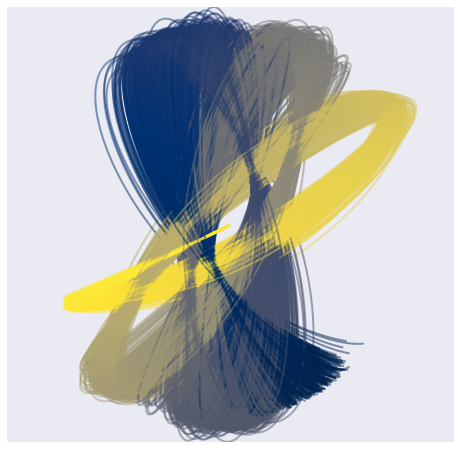

In [9]:
# plot particle trajectories
def make_segments(data, particle_index):
    points = np.array([data[:,particle_index, 0], data[:,particle_index, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

from matplotlib.collections import LineCollection
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark')
for i in range(N):
    lc = LineCollection(make_segments(paths, i), cmap='cividis', norm=plt.Normalize(0,1), alpha=0.5)
    # Set the values used for colormapping
    lc.set_array(np.linspace(1,0,T))
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])
plt.savefig('normal.png', dpi=90)
plt.show()